In [12]:
import os
from datetime import datetime
import shutil
from glob import glob
import rioxarray as rxr
from rioxarray.exceptions import NoDataInBounds
import rasterio.features
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display

In [13]:
#configure logging to file
import logging
log_path = f"data/output/logs/calibration_{datetime.now().strftime('%d%m%Y%H%M%S')}.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path,level=logging.INFO, format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.handlers.clear()
logger.addHandler(logging.StreamHandler())
logger.info("Starting procedure")

Starting procedure


In [14]:
PADDING = 1 #meters
CRS = "EPSG:32634"
TMP_DIR = "tmp"
if os.path.exists(TMP_DIR):
    shutil.rmtree(TMP_DIR)
os.mkdir(TMP_DIR)
TIFF_DIR = "data/output/tiff"
assert os.path.exists(TIFF_DIR), "tiff_dir does not exist. Please run 1_conversion.ipynb first."
GEOTIFF_OPTIM_DIR = "data/output/geotiff_optim"
assert os.path.exists(GEOTIFF_OPTIM_DIR), "geotiff_dir does not exist. Please run 1_conversion.ipynb first."
TIFF_CAL_DIR = "data/output/tiff_cal"
GEOTIFF_CAL_DIR = "data/output/geotiff_cal"

In [15]:
logger.info("Starting from scratch")
logger.info(f"Clearing {TIFF_CAL_DIR}")
if os.path.exists(TIFF_CAL_DIR):
    shutil.rmtree(TIFF_CAL_DIR)
os.makedirs(TIFF_CAL_DIR)
logger.info(f"Clearing {GEOTIFF_CAL_DIR}")
if os.path.exists(GEOTIFF_CAL_DIR):
    shutil.rmtree(GEOTIFF_CAL_DIR)
os.makedirs(GEOTIFF_CAL_DIR)

Starting from scratch
Clearing data/output/tiff_cal
Clearing data/output/geotiff_cal


In [16]:
logger.info("Reading footprints")
geometries = []
names = []
for path in tqdm(glob(f"{GEOTIFF_OPTIM_DIR}/*.tiff")):
    raster = rxr.open_rasterio(path)
    footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
    footprints = [Polygon(geom["coordinates"][0]).simplify(10).buffer(-PADDING) for geom, colval in footprints if colval == 1]
    assert len(footprints) == 1, "More than one footprint found"
    names.append(os.path.basename(path))
    geometries.append(footprints[0])
footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries})

Reading footprints
100%|██████████| 453/453 [01:12<00:00,  6.27it/s]


In [17]:
logger.info("Detecting intersections")
inters = []
geometries_buf = []
for i, i_geom in tqdm(footprints["geometry"].items()):
    inter = []
    for j, j_geom in footprints["geometry"].items():
        if i == j:
            continue
        if i_geom.intersects(j_geom):
            area = i_geom.intersection(j_geom).area
            inter.append({"id": j,"area": area})
    inter = sorted(inter, key=lambda k: k['area'], reverse=True)
    inters.append(inter)
    geometries_buf.append(i_geom)
footprints['geometry'] = geometries_buf
footprints['intersect'] = inters

Detecting intersections
453it [00:04, 109.43it/s]


In [18]:
logger.info("Initializing columns")
footprints['std']=None
footprints['weight']=None
footprints['offset']=None
footprints['calibrated']=False

Initializing columns


In [19]:
logger.info("Setting reference point and refrence photo")
# name = "DJI_20221220111743_0190_T.JPG.tiff"
# offset = 2.0-4.8
name = "DJI_20220324154305_0287_T.JPG.tiff"
offset = 8.0-2.75
raster = rxr.open_rasterio(os.path.join(GEOTIFF_OPTIM_DIR, name), masked=True)
raster.values = raster.values + offset
raster.rio.to_raster(os.path.join(GEOTIFF_CAL_DIR, name))
footprints.loc[footprints['name'] == name, 'offset'] = offset
footprints.loc[footprints['name'] == name, 'calibrated'] = True
footprints.loc[footprints['name'] == name, 'std'] = 0.0
footprints.loc[footprints['name'] == name, 'weight'] = None
centroid = footprints.loc[footprints['name'] == name, 'geometry'].centroid.values[0]
ref_points = gpd.GeoDataFrame(geometry=[centroid], data={'temperature': [8.0]}, crs='EPSG:32634')

Setting reference point and refrence photo


In [20]:
logger.info("Setting the calibration order")
id_dists = []
for id_i, row_i in tqdm(footprints.iterrows()):
    dists = []
    for point in ref_points['geometry']:
        dists.append(row_i['geometry'].centroid.distance(point))
    dist = min(dists)
    if not row_i['calibrated']:
        id_dists.append({"id": id_i, "dist": dist})
id_dists = sorted(id_dists, key=lambda k: k['dist'])

Setting the calibration order
453it [00:00, 2780.54it/s]


0.9517867149845024


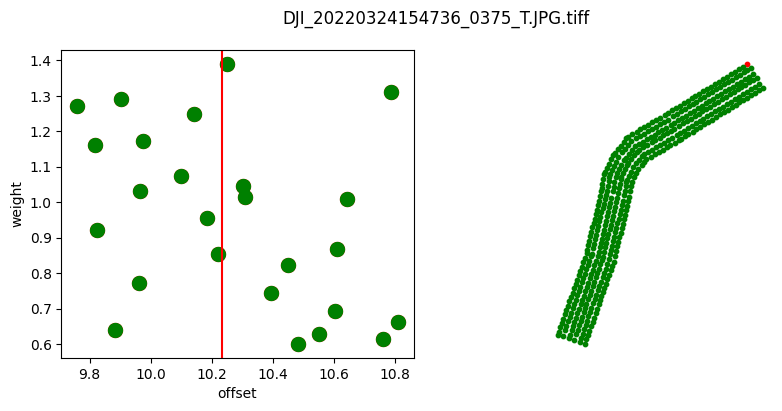

/usr/local/lib/python3.9/dist-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
Calibrated:: offset: 10.235070359764965, weight: 0.9517867149845024
100%|██████████| 452/452 [51:46<00:00,  6.87s/it]

    1 image files updated


In [21]:
logger.info("Calibrating pairs")
for id_dist in tqdm(id_dists):
    dst_id = id_dist['id']
    dst = footprints.iloc[dst_id]
    if dst['calibrated']:
        logger.info(f"{dst['name']} already calibrated, skipping")
        continue
    dst_raster = rxr.open_rasterio(f"{GEOTIFF_OPTIM_DIR}/{dst['name']}", masked=True)
    offsets = []
    weights = []
    logger.info(f"")
    logger.info(f"Calibrating:: dst: {dst['name']}")
    for inter in footprints.iloc[dst_id]['intersect']:
        if footprints.iloc[inter['id']]['calibrated']:
            src_id = inter['id']
            src = footprints.iloc[src_id]
            src_raster = rxr.open_rasterio(f"{GEOTIFF_CAL_DIR}/{src['name']}", masked=True)#.rio.clip([dst['geometry']])
            logger.info(f"Matching:: src: {src['name']}")
            intersection = src['geometry'].intersection(dst['geometry'])
            try:
                src_clip = src_raster.rio.clip([intersection])
                dst_clip = dst_raster.rio.clip([intersection])
            except NoDataInBounds:
                logger.info(f"NoDataInBounds")
                continue
            dst_clip = dst_clip.rio.reproject_match(src_clip)
            diff = (src_clip.values-dst_clip.values).flatten()
            weight = 1./np.nanstd(diff)#inter['area']
            offset = np.nanmean(diff)
            #assert offset is not nan
            if np.isnan(offset):
                logger.info(f"offset is nan")
                continue
            logger.info(f"offset: {offset}, weight: {weight}")
            offsets.append(offset)
            weights.append(weight)
        
    offsets = np.array(offsets)
    weights = np.array(weights)
    offsets_all = offsets.copy()
    weights_all = weights.copy()
    if len(offsets) > 1:
        indices = np.abs(offsets - np.mean(offsets)) < 2*np.std(offsets) #remove outliers
        offsets = offsets[indices]
        weights = weights[indices]
    weight = weights.mean()
    offset = (offsets*weights).sum()/weights.sum()

    #Display
    display.clear_output(wait=True)
    print(weight)
    #create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    # set figure title
    fig.suptitle(f"{dst['name']}")
    #plot offsets against weights
    ax1.scatter(offsets_all, weights_all, s=100, color='red')
    ax1.scatter(offsets, weights, s=100, color='green')
    ax1.set_xlabel('offset')
    ax1.set_ylabel('weight')
    ax1.axvline(offset, color='r')
    # plot points
    #plot footprints centroids where calibrated=False
    footprints[footprints['calibrated']==False].centroid.plot(ax=ax2, color='red', markersize=10)
    #plot footprints centroids where calibrated=True
    footprints[footprints['calibrated']==True].centroid.plot(ax=ax2, color='green', markersize=10)
    #hide axis
    ax2.axis('off')
    plt.show()

    std = np.std(offsets) if len(offsets) > 1 else 0.0
    footprints.loc[dst_id, 'std'] = std
    footprints.loc[dst_id, 'weight'] = weight
    footprints.loc[dst_id, 'offset'] = offset
    footprints.loc[dst_id, 'calibrated'] = True
    dst_raster.values = dst_raster.values + offset
    dst_raster.rio.to_raster(f"{GEOTIFF_CAL_DIR}/{dst['name']}")
    tiff = rxr.open_rasterio(f"{TIFF_DIR}/{dst['name']}")
    tiff.values = (tiff.values+offset)
    tiff.rio.to_raster(f"{TIFF_CAL_DIR}/{dst['name']}")
    os.system(f"exiftool -tagsfromfile {TIFF_DIR}/{dst['name']} {TIFF_CAL_DIR}/{dst['name']} -overwrite_original_in_place")
    logger.info(f"Calibrated:: offset: {offset}, weight: {weight}")

In [22]:
offset

10.235070359764965